# desc-wfmon/monexp.ipynb: Monitor explorer example

We use the classes in desc-wfmon to view monitoring data from DESC gen3 parsl jobs.

Typically, this file is copied to the area where the jobs were run.

The following sets up to use the local install area, installs desc-wfmon there if needed, and then imports the the system (sysmon) and process (wfmon) monitor explorers. To force a rebuild of desc-wfmon, remove ./install.

In [1]:
print('Notebook version is 7.9')
import sys
import os
import datetime
homedir = os.getenv('HOME')
print(f"Current directory is {os.getcwd()}")
stzone = datetime.datetime.utcnow().astimezone().tzinfo
print(f"Local time zone is {stzone}")
srcdir = f"{homedir}/desc/dev"
nbdir = srcdir + '/desc-wfmon/ipynb'
%run $nbdir/setup.ipynb
print('Checking for local install of desc-wfmon')
%run install/setup.py

print(f"Python version is {sys.version}")
print(f"Python search path starts with {sys.path[0]}:{sys.path[1]}:{sys.path[2]}")
!pwd
import pandas
import numpy
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
import desc.wfmon
import desc.sysmon
for pkg in [desc.wfmon, desc.sysmon]:
    print(f"{pkg} version is {pkg.__version__}")


Notebook version is 7.8
Current directory is /pscratch/sd/d/dladams/descprod-out/jobs/job000804
Local time zone is PDT
login20:/pscratch/sd/d/dladams/descprod-out/jobs/job000804: Thu 31 Aug 2023 03:09:46 PM PDT
Setting up desc-wfmon
Python version is 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
Python search path starts with ./install/noconda
/pscratch/sd/d/dladams/descprod-out/jobs/job000804
TestMonDbReader:ctor: Done.
<module 'desc.wfmon' from '/pscratch/sd/d/dladams/descprod-out/jobs/job000804/./install/noconda/desc/wfmon/__init__.py'> version is 0.26.14
<module 'desc.sysmon' from '/pscratch/sd/d/dladams/descprod-out/jobs/job000804/./install/noconda/desc/sysmon/__init__.py'> version is 0.26.14
login20: Thu 31 Aug 2023 03:09:46 PM PDT
Checking for local install of desc-wfmon
Python version is 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
Python search path starts with ./install/noconda:/pscratch/sd/d/dladams/descprod-

## Configuration
Define some useful constants and specify the location of the monitoring data files. Set dir to point to your area.

In monexp.py, define object monexp with attributes that override any of those in monexp_def below.

In [2]:
# Read the config.
%run monexp.py

# Defaults for configuration.
class monexp_def:
    dir = os.getcwd()
    name = os.path.basename(os.getcwd())
    run_id = None
    stunit = 'minute'           # Unit for time axes
    sbunit = 'gb'               # Unit for memory, I/O
    tmin = 0                    # Min time for time axes
    tmax = 20                   # Max time for time axes
    taskrunmax = 130            # Max for running task axes
    taskrunmax_pernode = False  # If true taskrunmax is scaled by nnod
    tasktimemax = 200           # Max for time/task axis [s]
    taskcount_interval = 10     # Sampling interval for evaluating try task counts
    tzoff = 0                   # Time zone offset between system and process monitors
    tlatencymax = 20            # Max for latency axis
    tlatrunmax = 100            # Max for lataency + run time
    iosummax = 1000             # Max for the integrated I/O plot [GB]
    task_id_plot = None         # Task index or type for latency plots (e.g. 0 or 'isr')
    t0_source = "system"        # 'system' for sysmon, 'run' for run start of first task
    
# Set defaults for any missing parameters.
if 'monexp' not in dir():
    monexp = monexp_def
else:
    for nam in monexp_def.__dict__:
        if nam[0:2] == '__': continue
        if not hasattr(monexp, nam):
            setattr(monexp, nam, getattr(monexp_def, nam))
        
# Time conversions and plotting units.
tunits = {'second':1, 'minute':60, 'hour':3600, 'day':24*3600}
stunit = monexp.stunit
tunit = tunits[stunit]

# Memory and I/O conversion plotting units.
bunits = {'mb':2**20, 'gb':2**30}
gb = bunits['gb']
sbunit = monexp.sbunit
bunit = bunits[sbunit]
bunit_sys = bunit/gb

# Time range for the plots
# if tmax <= tmin, it will be reset with the data below
tmin = monexp.tmin
tmax = monexp.tmax

print(f"Time zone offset: {monexp.tzoff} sec")

# Plot size
pdx = 20
pdy = 6

line = '-----------------------------------------------------------'
fread = monexp.dir + '/README.txt'
if os.path.exists(fread):
    fin = open(fread, 'r')
    #readme = fin.read().strip()
    readme = fin.readlines()
    with open(fread) as fin:
        readme = [line.rstrip() for line in fin]
else:
    raise Exception('README.txt not found')
print('README:')
for line in readme: print(line)
pttl = monexp.name + ": " + readme[0]
print(f"Plot title: {pttl}")
pfx = monexp.name
print(f"Plot file prefix: {pfx}")
sfx = '.png'
print(f"Plot file suffix: {sfx}")
plt.rc('font', size=16)
plt.rc('savefig', facecolor='white', bbox='tight')
plt.rc('axes', titlesize='medium')

pandas.options.display.width = 150

Time zone offset: 0 sec
README:
Job 804
Plot title: job000804: Job 804
Plot file prefix: job000804
Plot file suffix: .png


## Fetch system-level monitoring data

System level monitoring data is collected using *desc.sysmon*. The data is in csv format and is read here with *pandas*.

The column names follow from those of the corresponding *psutil* variables.

We fetch the number of CPUs and total memory and check both are consistent for all samples.

In [3]:
havesym = False
ncpu = 1
try:
  sym = pandas.read_csv(monexp.dir + '/sysmon.csv')
  havesym = True
  print(f"System monitor sample count: {len(sym)}")
  print(f"System monitor columns:")
  for cnam in sym.columns:
    print(f"  {cnam}")
  
  assert(len(sym.cpu_count.unique()) == 1)
  ncpu = sym.cpu_count[0]
  print(f"CPU count is {ncpu:.0f}")

  assert(len(sym.mem_total.unique()) == 1)
  maxmem = sym.mem_total[0]/bunit_sys
  print(f"Total memory is {maxmem:.1f} {sbunit}")
except:
  print(f"WARNING: System monitoring data not found.")


System monitor sample count: 318
System monitor columns:
  time
  cpu_count
  cpu_percent
  cpu_freq
  cpu_user
  cpu_system
  cpu_idle
  cpu_iowait
  cpu_time
  mem_total
  mem_available
  mem_swapfree
  dio_readsize
  dio_writesize
  nio_readsize
  nio_writesize
CPU count is 256
Total memory is 503.2 gb


## Fetch the process-level monitoring data

The process monitoring data is read from the mysql DB produced by parsl. Of particular interest is the task table where metrics are sampled at regular intervals seprately for each job.

We "fix" that data to make it more amenable for analysis. Among many other modifications, fixing converts time strings to integers and add a procsum (process summary) table which sums the contributions from all jobs. Although the sampling interval is the same for all jobs, they have different offsets and so there is some ambiguity in this summing.

For disk and network I/O, integrated values are recorded but the differential values (the amount read or written each sampling interval) are of interest here. A separate call is made to build a procsum table that includes these differential values. This is not done automatically because it can be slow.

In [4]:
dbg = 1
showraw = False
for subdir in ['', '/runinfo']:
    fnam = f"{monexp.dir}{subdir}/monitoring.db"
    if os.path.exists(fnam):
        if showraw:
            dbr = desc.wfmon.MonDbReader(fnam, fix=False, dodelta=False, dbg=dbg)
            print('----------- Workflow ------------------')
            print(dbr['workflow'])
            print('---------------------------------------')
        else:
            dbr = desc.wfmon.MonDbReader(fnam, dodelta=True, dbg=dbg, run_id=monexp.run_id)
print(f"Label: {pttl}")
dbr.tables(2)

MonDbReader::fix_runs: Fixing runs.
MonDbReader::fix_workflows: Fixing workflows.
MonDbReader::fix_times: Fixing times.
MonDbReader::fix_tasks: Fixing tasks.
MonDbReader::fix_tasks: WARNING: Not found in running status table: run_idx==0 and task_id==0 and try_id==0
MonDbReader::fix_tasks: WARNING: Not found in running_ended status table: run_idx==0 and task_id==0 and try_id==0
MonDbReader::fix_tasks: WARNING: Not found in exec_done status table: run_idx==0 and task_id==0 and try_id==0
MonDbReader::fix_tasks: WARNING: Not found in running status table: run_idx==0 and task_id==1 and try_id==0
MonDbReader::fix_tasks: WARNING: Not found in running_ended status table: run_idx==0 and task_id==1 and try_id==0
MonDbReader::fix_tasks: WARNING: Not found in exec_done status table: run_idx==0 and task_id==1 and try_id==0
MonDbReader::fix_tasks: WARNING: Not found in running status table: run_idx==0 and task_id==2 and try_id==0
MonDbReader::fix_tasks: WARNING: Not found in running_ended status tab

## Run selection
Define handles for the process tables of interest:

* wkf - Workflow table with one entry for each run
* tsk - Task table holds a description of each task
* tst - Try table has entry each time a task is run or rerun
* prc - Process table holds sampled data for each process
* psm - Procsum (process summary) table holds samples summed over all processes

If the process monitor includes more than one run, then select one run to study here.

In [5]:
nrun = len(dbr.table('workflow'))
if nrun == 1:
    print('One run found.')
    wkf = dbr.table('workflow')
    tsk = dbr.table('task')
    tst = dbr.table('try')
    prc = dbr.table('resource')
    psm = dbr.table('procsum')
else:
    rqry = 'run_idx==0'
    print(f"Selecting runs with {rqry}")
    wkf = dbr.table('workflow').query(rqry)
    tsk = dbr.table('task').query(rqry)
    tst = dbr.table('try').query(rqry)
    prc = dbr.table('resource').query(rqry)
    psm = dbr.table('procsum').query(rqry)
print(f"Process table entry count: {len(prc)}")
print(f"Procsum table entry count: {len(psm)}")
if havesym:
    print(f" System table entry count: {len(sym)}")
else:
    print(f"System table was not found.")
have_procsum = len(psm) > 0

print(f"Run nodes: {tst.hostname.dropna().unique()}")
print(f"Workflow count: {len(dbr['workflow'])}")

One run found.
Process table entry count: 12408
Procsum table entry count: 486
 System table entry count: 318
Run nodes: ['nid007134']
Workflow count: 1


## Task counts

In [6]:
ntsk = len(tsk)
ntry = len(tst)
ntsk_good = wkf.at[0, 'tasks_completed_count']
ntsk_fail = wkf.at[0, 'tasks_failed_count']
fmt = f"{len(str(ntsk))}d"
print(f"   Task failed count: {ntsk_fail:{fmt}}/{ntsk}")
print(f"Task succeeded count: {ntsk_good:{fmt}}/{ntsk}")

   Task failed count:   0/995
Task succeeded count: 452/995


## Run nodes
Fetch the list of processing nodes.

In [7]:
nodes = tst.hostname.dropna().unique()
nnod = len(nodes)
if nnod == 1:
    print(f"The run used one node: {nodes[0]}")
else:
    print(f"The run used {nnod} nodes: {nodes}")
taskrunmax = monexp.taskrunmax
if monexp.taskrunmax_pernode:
    taskrunmax = taskrunmax * nnod

The run used one node: nid007134


## Time range

For convenience we add a column tfix to each table that converts to units defined above. The try table includes three state timees:
* launched - The task is made ready to run
* running - The CPU process starts. (Not present when process monitoring is disabled.)
* returned - The CPU process terminates.  

The zero for time is the first entry in the system monitor if present. Otherwise the value from process monitor is used. The difference between these (in the selected time units) is recorded in dtfix
The time offset used in the process tables is applied to the system table. A configureable offset is also added, e.g. to account for time zone issues.

In [8]:
delt = dbr.monitoring_interval
if delt is None : delt = 0.0
deltfix = delt/tunit
dtfix = 0.0
nttry = len(tst)
ntlau = tst.task_try_time_launched.notna().sum()
ntrun = tst.task_try_time_running.notna().sum()
ntret = tst.task_try_time_returned.notna().sum()
print(f"Task returned/run/launched/try count: {ntret}/{ntrun}/{ntlau}/{nttry}")
# t0sec is our zero of time in the parsl monitor time zone
if monexp.t0_source == 'system':
    t0sec_sym = sym.time[0]
    t0sec_dbr = t0sec_sym - monexp.tzoff
elif monexp.t0_source == 'run':  
    t0sec_dbr = tst.task_try_time_running.min() + dbr.t0
    t0sec_sym = t0sec_dbr + monexp.tzoff
else:
    raise Exception(f"Invalid t0_source: {monexp.t0_source}")
dtfix = (t0sec_dbr - dbr.t0)/tunit
if havesym:
    deltsys = (max(sym.time) - min(sym.time))/float(len(sym) - 1)
wkf['tfix_began']     = wkf.time_began/tunit - dtfix
wkf['tfix_completed'] = wkf.time_completed/tunit - dtfix
newlatency = True
if newlatency:
    tst['trun'] = tst.status_rundone - tst.status_running  # process run time
    tst['tpst'] = tst.status_alldone - tst.status_rundone  # post-processing time
else:
    tst['trun'] = tst.task_try_time_returned - tst.task_try_time_running
tst['tfix_launched']  = tst.task_try_time_launched/tunit - dtfix
tst['tfix_running']   = tst.task_try_time_running/tunit - dtfix
tst['tfix_returned']  = tst.task_try_time_returned/tunit - dtfix
tsk['tfix_invoked']   = tsk.task_time_invoked/tunit - dtfix
prc['tfix']           = prc.timestamp/tunit - dtfix
if have_procsum:
    psm['tfix'] = psm.timestamp/tunit - dtfix
    psm_tfix = psm['tfix']
    psm_interval_tfix = pandas.concat([pandas.Series([(psm_tfix[0]-deltfix)]), psm_tfix])
if havesym:
    sym['tfix'] = (sym.time - t0sec_sym)/tunit

twkf1 = wkf.tfix_began.min()
twkf2 = wkf.tfix_completed.max()
tlau1 = tst.tfix_launched.min()
tlau2 = tst.tfix_launched.max()
tinv1 = tsk.tfix_invoked.min()
tinv2 = tsk.tfix_invoked.max()
tprc1 = prc.tfix.min()
tprc2 = prc.tfix.max()
if have_procsum:
    tpsm1 = psm.tfix.min()
    tpsm2 = psm.tfix.max()
if havesym:
    tsym1 = sym.tfix.min()
    tsym2 = sym.tfix.max()
if tmax <= tmin:
    tmax = 1.01*tprc2

print(f"T0 source: {monexp.t0_source}")
print(f"System/process TZ offset: {monexp.tzoff} sec")
print(f"  Proc time interval: {delt:.2f} sec")
if havesym:
    print(f"   Sys time interval: {deltsys:.2f} sec")
print(f" Workflow time range: ({twkf1:.2f}, {twkf2:.2f}) {stunit}")
print(f"   Invoke time range: ({tinv1:.2f}, {tinv2:.2f}) {stunit}")
print(f"   Launch time range: ({tlau1:.2f}, {tlau2:.2f}) {stunit}")
print(f"  Process time range: ({tprc1:.2f}, {tprc2:.2f}) {stunit}")
if have_procsum:
    print(f"  Procsum time range: ({tpsm1:.2f}, {tpsm2:.2f}) {stunit}")
if havesym:
    print(f"   System time range: ({tsym1:.2f}, {tsym2:.2f}) {stunit}")
print(f" Plotting time range: ({ tmin:.2f}, { tmax:.2f}) {stunit}")

Task returned/run/launched/try count: 452/476/995/995
T0 source: system
System/process TZ offset: 0 sec
  Proc time interval: 3.00 sec
   Sys time interval: 5.07 sec
 Workflow time range: (1.17, 26.70) minute
   Invoke time range: (2.28, 2.49) minute
   Launch time range: (2.28, 2.49) minute
  Process time range: (2.39, 26.70) minute
  Procsum time range: (2.40, 26.65) minute
   System time range: (0.00, 26.76) minute
 Plotting time range: (0.00, 30.00) minute


## Tasks
We look at the task types, how many of each were run and plot the distribution of run times for the tasks.

If process monitoring was disabled then the run start times are not recorded in the try table and the run time plots are empty.

         Task idx count: 1
             Task count: 995
      Unique task count: 995
              Try count: 995
         Try done count: 452
  Max task by tid count: 995

Task name [done/count]
   0: isr [452/452/995] 74.8


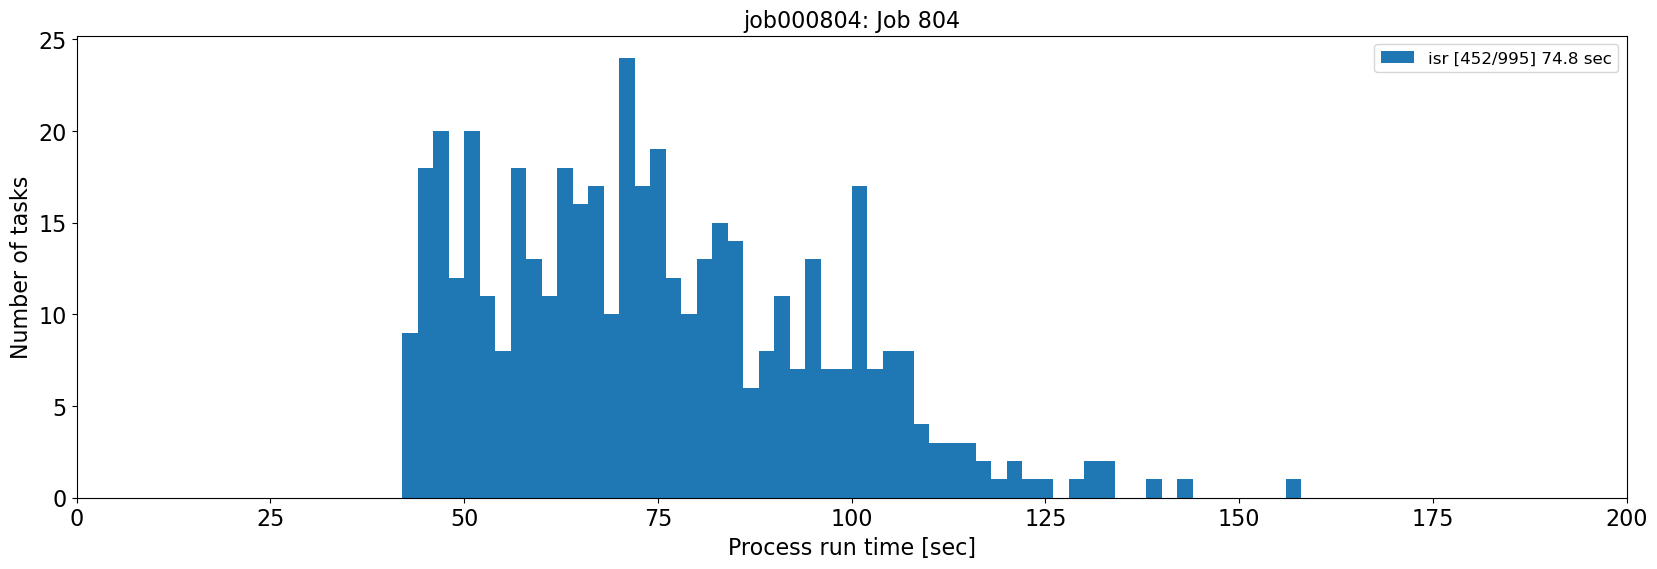

In [9]:
ntid = len(tsk.task_idx.unique())
ntry = len(tst)
trunMax = (tst.task_try_time_running - tst.task_try_time_launched).dropna().max()
tstDone = tst.query("task_try_time_returned==task_try_time_returned")
ntryDone = len(tstDone)
ntskByTid = []
for itid in range(ntid):
    ntskByTid.append(len(tsk.query(f"task_idx=={itid}")))
ntskByTidMax = max(ntskByTid)
print(f"         Task idx count: {ntid}")
print(f"             Task count: {ntsk}")
print(f"      Unique task count: {len(tsk.task_id.unique())}")
print(f"              Try count: {ntry}")
print(f"         Try done count: {ntryDone}")
print(f"  Max task by tid count: {ntskByTidMax}")

print()
print("Task name [done/count]")
assert(ntid == len(dbr.task_names))
tstDoneByTask = [None]*ntid
tstRunTimeByTask = [None]*ntid
for itid in range(ntid):
    tstDoneByTask[itid] = tstDone.query(f"task_idx=={itid}")
    if newlatency:
        t1 = tstDoneByTask[itid].status_running
        t2 = tstDoneByTask[itid].status_rundone
    else:
        t1 = tstDoneByTask[itid].task_try_time_running
        t2 = tstDoneByTask[itid].task_try_time_returned
    tstRunTimeByTask[itid] = (t2 - t1).dropna()
    td = tstRunTimeByTask[itid]
    ndif = len(td)
    nrun = t1.count()
    ndone = t2.count()      # count ignores NaN
    if ndone == 0:
        savg = ""
    elif nrun == 0:
        savg = "" if ntrun == 0 else f"Run start times not found"
    elif ndif != ndone:
        savg = f"ERROR: Inconsistent run start and returned entries"
    elif len(td):
        avg = td.mean()
        savg = f" {avg:.1f}"
    else:
        savg = ''
    print(f"{itid:4}: {dbr.task_names[itid]} [{ndone}/{nrun}/{dbr.task_name_counts[itid]}]{savg}")


x1 = 0
x2 = monexp.tasktimemax
# Fetch run times for each type of task
taskdts = [None]*ntid
cols = [None]*max(ntid,3)
ncol = len(cols)
labs = [None]*ntid
#mycols = ['red', 'green', 'orange', 'blue', 'yellow', 'violet', 'cyan', 'pink']
for itid in range(ntid):
    td = tstRunTimeByTask[itid]
    if len(td):
        avg = td.mean()
        savg = f" {avg:.1f}"
    else:
        savg = ''
    taskdts[itid] = td.clip(upper=0.999*x2)
    labs[itid] = f"{dbr.task_names[itid][0:20]} [{len(tstDoneByTask[itid])}/{dbr.task_name_counts[itid]}]{savg} sec"
plt.figure(figsize=(pdx, pdy))
plt.hist(bins=100, range=(x1, x2), x=taskdts, stacked=True, label=labs)
plt.legend(loc="upper right", fontsize=12)
if newlatency:
    plt.xlabel('Process run time [sec]')
else:
    plt.xlabel('Time: returned - running [sec]')
plt.ylabel('Number of tasks')
junk = plt.xlim([x1, x2])
plt.title(pttl)
plt.savefig(pfx+'ttask'+sfx)

## Throughput per task type

The *taskcounts* method uses the task state times from the try table to evaluate the integrated number of tasks that have reached each of the task states
(launched, running, returned) as a function of time.

If there is more than one task type, we plot this for the running and returned states with a separate curve for each type.

In [10]:
if tprc2 > 0.8*tmax:
    legloc = "upper left"
else:
    legloc = "upper right"
print(f"Task count interval: {monexp.taskcount_interval}")
dbr.taskcounts(delt=monexp.taskcount_interval)
for dfs in dbr._taskcounts:
    for idf in dfs:
        dfs[idf]['tfix'] = dfs[idf].time/tunit - dtfix
#dbr._taskcounts[0]['running']
#print(dbr.taskcounts('returned', 0))
state = 'running'
tsclau = dbr.taskcounts('launched')
tscrun = dbr.taskcounts('running')
tscret = dbr.taskcounts('returned')
tscact = tscrun - tscret   # Number of task running
# Evaluate the times at which all tasks are launched, started and running.
tfix_procs_launched = tsclau.at[tsclau.idxmax()['all'], 'tfix']
tfix_procs_running  = tscrun.at[tscrun.idxmax()['all'], 'tfix']
tfix_procs_done     = tscret.at[tscret.idxmax()['all'], 'tfix']
print(f"Last task return time: {tfix_procs_done:0.2f} {stunit}")
if ntid > 1:
    for sstat in ['running', 'returned']:
        plt.figure(figsize=(pdx, pdy))
        tsc = dbr.taskcounts(sstat)
        for itid in range(ntid):
            plt.plot(tsc.tfix, tsc[itid], '.', color=cols[itid%ncol], label=labs[itid])
        plt.xlabel(f"Time [{stunit}]")
        plt.ylabel(f"Integrated {sstat} task count")
        plt.legend(loc=legloc, fontsize=10)
        plt.grid(True)
        junk = plt.axis([tmin, tmax, 0, 1.02*ntskByTidMax])
        plt.title(pttl)
        plt.savefig(f"{pfx}sn{sstat[0:3]}{sfx}")
        plt.show()

Task count interval: 1
TestMonDbReader:taskcounts: Evaluating taskcounts.
Last task return time: 26.69 minute


## Launch rate
Estimate launch rate using the first sample with launched tasks and the last before the maximum.

In [11]:
isam1 = None
for isam in range(len(tsclau)):
    ntaskl = tsclau['all'][isam]
    if isam1 is None and ntaskl > 0: isam1 = isam
    if ntaskl >= ntsk: break
isam2 = isam - 1
if isam1 is not None and isam2 > isam1:
    tsaml1 = tsclau.tfix[isam1]
    tsaml2 = tsclau.tfix[isam2]
    ntskl1 = tsclau['all'][isam1]
    ntskl2 = tsclau['all'][isam2]
    dtsaml = tsaml2 - tsaml1
    dntskl = ntskl2 - ntskl1
    launch_rate = dntskl/dtsaml/tunit
    launch_time = 1./launch_rate
    print(f"Launch samples: [{isam1}..{isam2}]")
    print(f"Launch rate is {launch_rate:.1f} Hz  ({ntskl2:.1f} - {ntskl1:.1f} = {dntskl:.0f} tasks in {dtsaml:.3f} {stunit})")
    print(f"Launch time is {1000.0/launch_rate:.1f} msec")
else:
    print('Unable to evaluate launch rate.')

Launch samples: [66..79]
Launch rate is 76.0 Hz  (991.0 - 3.4 = 988 tasks in 0.217 minute)
Launch time is 13.2 msec


## Throughput

This figure shows the total number of jobs launched, started and finished as function of time.
The time at which the last task completes is the time for the run (workflow) and is shown on the plot.

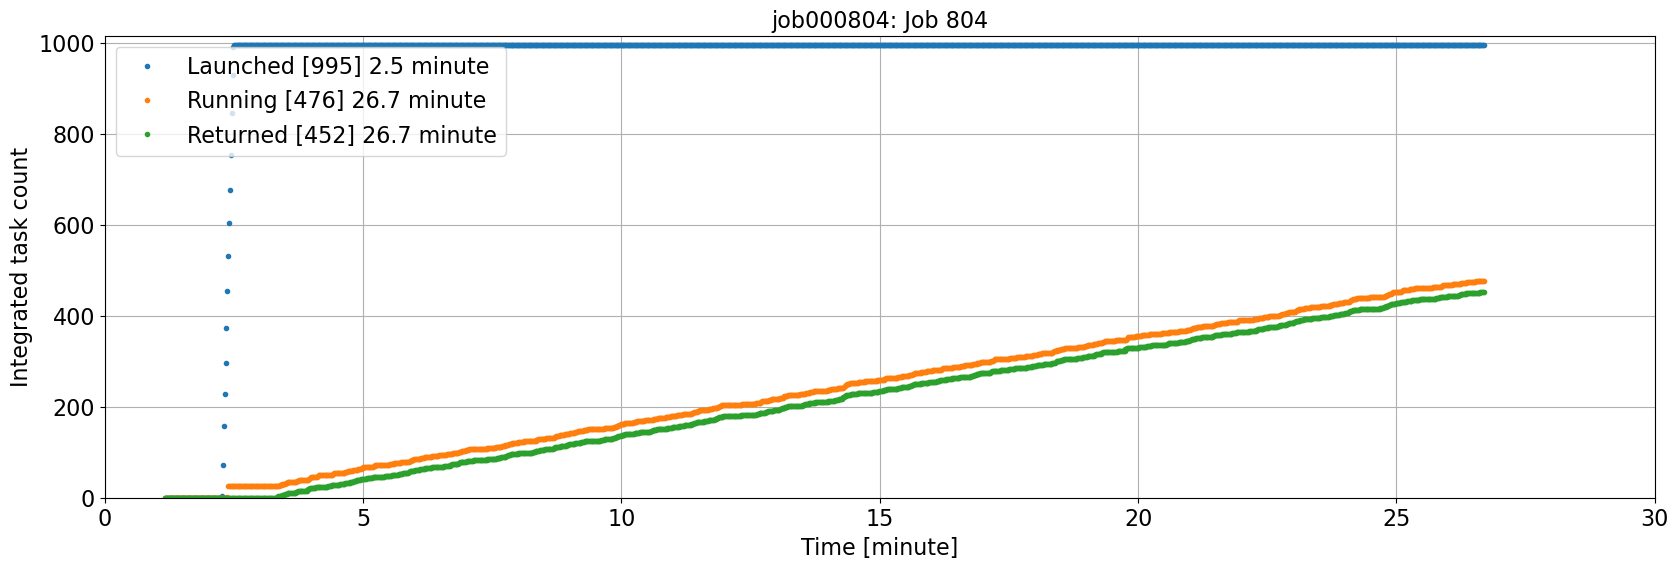

In [12]:
plt.figure(figsize=(pdx, pdy))
plt.plot(tsclau.tfix, tsclau['all'], '.', color=cols[0], label=f"Launched [{tsclau['all'].max():.0f}] {tfix_procs_launched:.1f} {stunit}")
plt.plot(tscrun.tfix, tscrun['all'], '.', color=cols[1], label=f"Running [{tscrun['all'].max():.0f}] {tfix_procs_running:.1f} {stunit}")
plt.plot(tscret.tfix, tscret['all'], '.', color=cols[2], label=f"Returned [{tscret['all'].max():.0f}] {tfix_procs_done:.1f} {stunit}")
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Integrated task count')
plt.legend(loc=legloc)
plt.grid(True)
ymin = 0
ymax = 1.02*ntsk
junk = plt.axis([tmin, tmax, ymin, ymax])
if ntryDone == ntry and tfix_procs_done <= tmax:
    tlab = tfix_procs_done
    wx = tmax - tmin
    wy = ymax - ymin
    if tlab > 0.8*tmax:
        ha = 'right'
        dx = -0.005*wx
    else:
        ha = 'left'
        dx = 0.005*wx
    plt.plot([tlab, tlab], [ymin, ymax], color='gray', linestyle='-')
    plt.text(tlab + dx, ymin + 0.015*wy, f"{tlab:.1f} {stunit}", ha=ha)
plt.title(pttl)
plt.savefig(pfx+'throughput'+sfx)

## Running task count

The difference between the integrated running and returned task counts provides the number of active tasks as a function of time.
Separates curves are plotted here for each task type and for all combined.

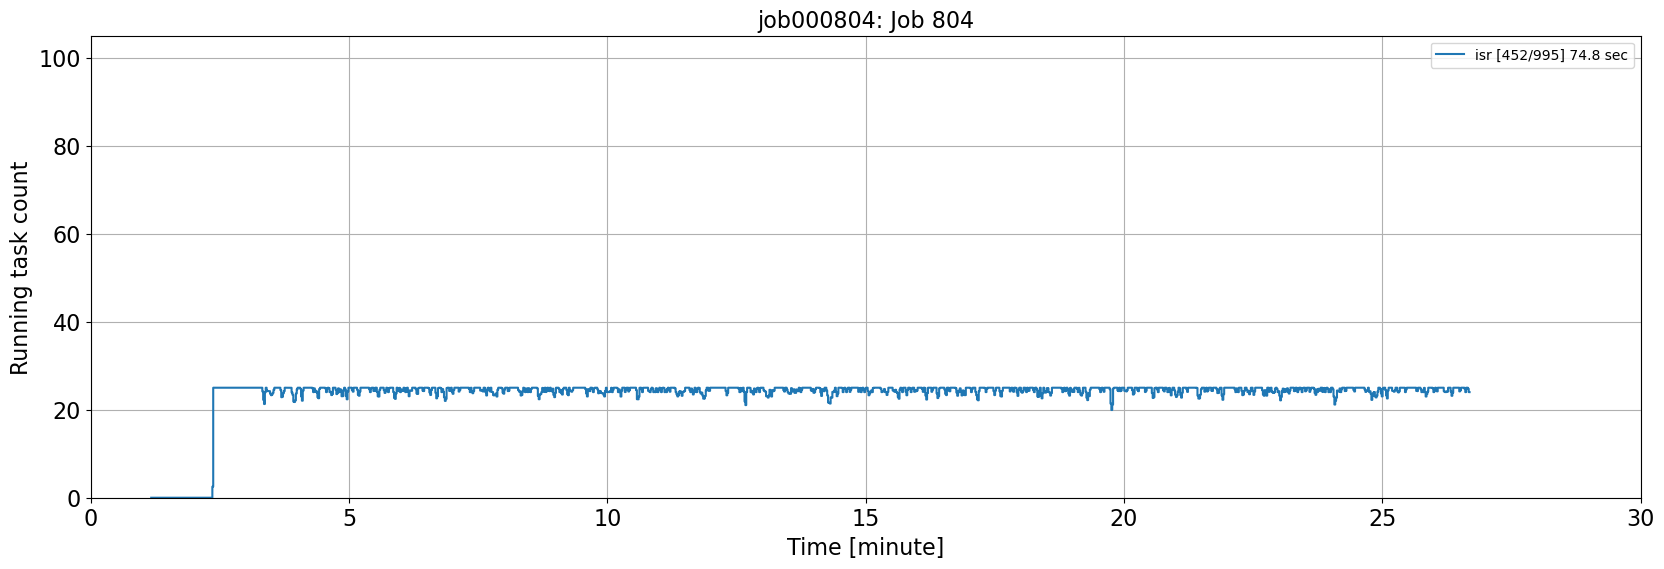

In [13]:
xmin = tmin
xmax = tmax
ymin = 0
ymax = taskrunmax
plt.figure(figsize=(pdx, pdy))
tscact = (tscrun['all'] - tscret['all'])
if ntid > 1: plt.step(x=tscrun.tfix, y=tscact, color='black', label='all')
for itid in range(ntid):
    ytmp = tscrun[itid] - tscret[itid]
    plt.step(x=tscret.tfix, y=ytmp, color=cols[itid%ncol], label=labs[itid])
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Running task count')
plt.legend(fontsize=10)
plt.title(pttl)
#plt.setp(plt.gca().get_legend().get_texts(), fontsize='8')
plt.grid(True)
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'nruntask'+sfx)

## Procsum estimate of running task count

The preceding estimate of running task count is based on the recorded process start and stop times and so can be evaluated precisely at a very fine time granularity.
The running task count can also be estimated from the procsum table but the time resolution is limited by the resource sampling frequency.
The two are overlaid in the following plot.
This is an important check because the following procsum estimates of utilization and I/O (which cannot be obtained otherwise) have the same limitations.

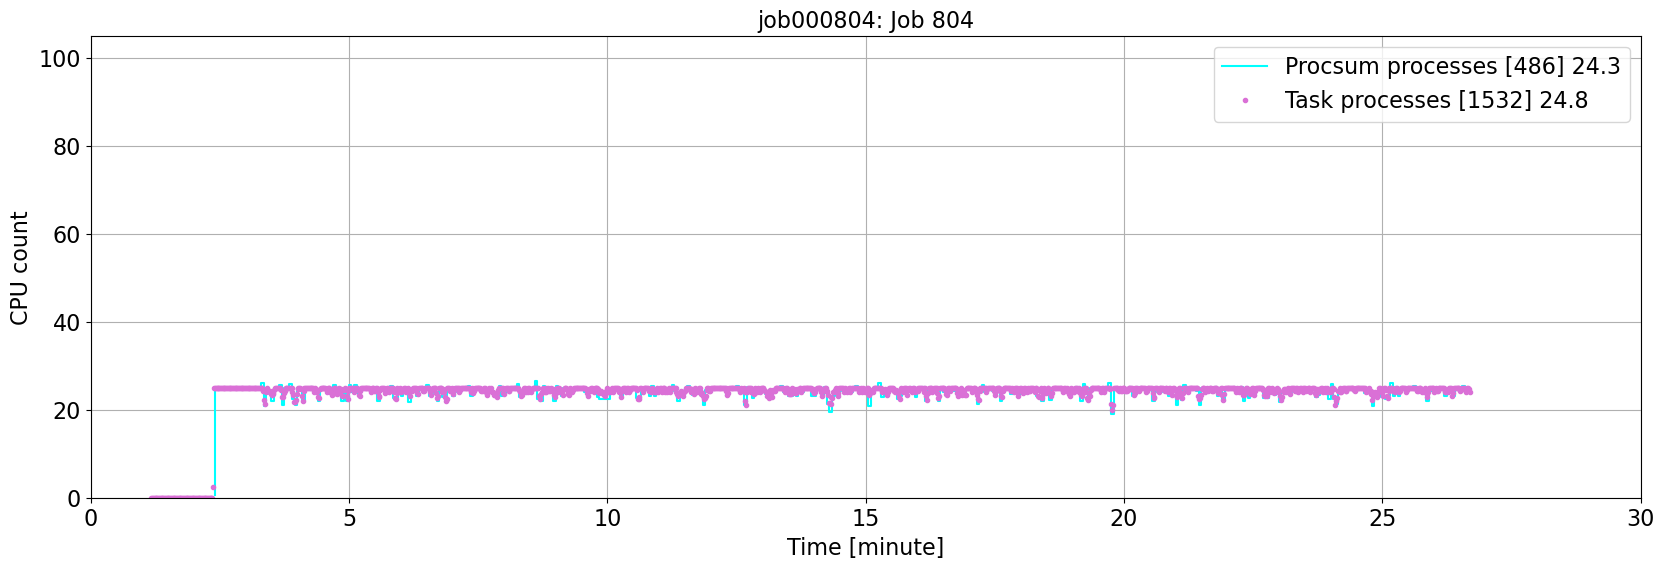

In [14]:
if have_procsum:
    xmin = tmin
    xmax = tmax
    #xmin = 4
    #xmax = 8
    ymin = 0
    ymax = taskrunmax
    plt.figure(figsize=(pdx, pdy))
    psmproc = psm.procsum_time_clock/delt
    #plt.step(x=tscrun.tfix, y=tscact, color='black', label='all')
    plt.step(x=psm_tfix, y=psmproc, where='pre', color='cyan', label=f"Procsum processes [{len(psmproc)}] {psmproc.median():.1f}")
    plt.plot(tscrun.tfix, tscact, '.', color='orchid', label=f"Task processes [{len(tscact)}] {tscact.median():.1f}")
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('CPU count')
    plt.grid(True)
    plt.legend()
    junk = plt.axis([xmin, xmax, ymin, ymax])
    plt.title(pttl)
    plt.savefig(pfx+'proccount'+sfx)

## CPU utilization

The CPU utilization is the fraction of time each "CPU" is working, i.e. not in the idle state. The system monitor gets this direcly from *psutil.cpy_percent* which return a value averaged over time since the last sampling and averaged over all hyperthreads.
We obtain an estimate for running task processes by summing the times each process spends in the user and system states and the dviding by the sampling time and total number of available hyperthreads.

The following plot shows these two values as a function of time.
We expect the system values to be larger because they include CPU used by the workflow and monitoring systems.

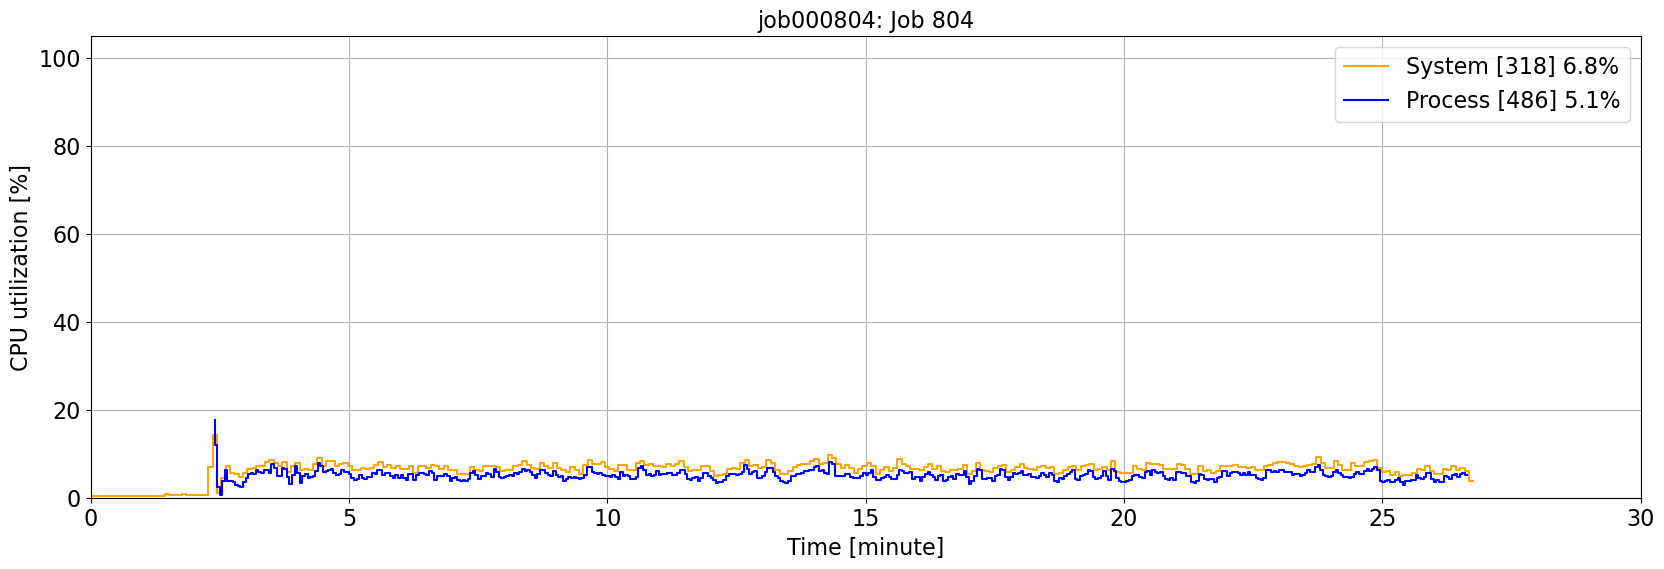

In [15]:
xmin = tmin
xmax = tmax
ymin = 0
ymax = 105
plt.figure(figsize=(pdx, pdy))
if havesym:
    cpp = sym.cpu_percent
    plt.step(x=sym.tfix, y=cpp, where='pre', color='orange', label=f"System [{len(cpp)}] {cpp.median():.1f}%")
# To get a process estimate, we divide the total user+sys time by the time interval and number of CPU.
if have_procsum:
    peff = 100*(psm.procsum_time_user+psm.procsum_time_system)/delt/ncpu
    plt.step(x=psm.tfix, y=peff, color='blue', label=f"Process [{len(peff)}] {peff.median():.1f}%")
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('CPU utilization [%]')
plt.grid(True)
plt.legend()
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'cpueff'+sfx)

## Task count and utilization
Here we overlay the running task count with the total task utilization now normalized to the number of CPUs (hyperthreads).
For perlmutter, that number is 256.

Utilization count: 486


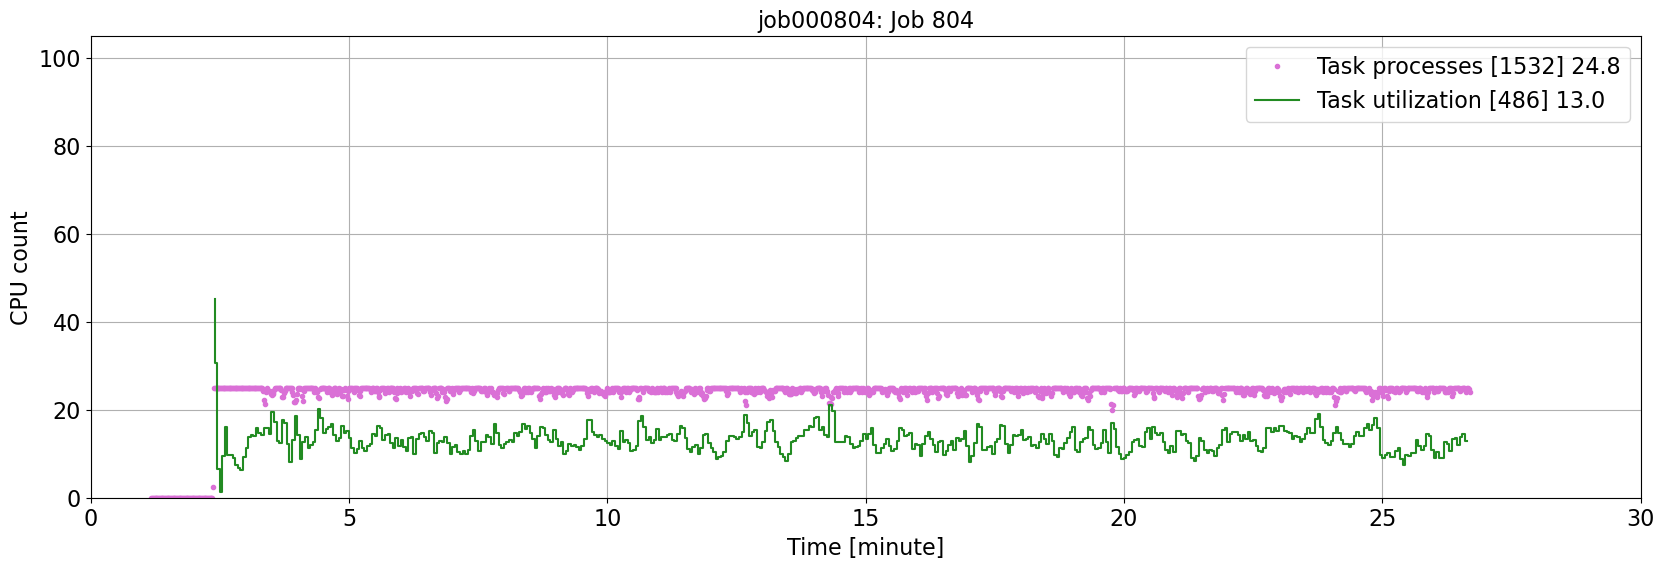

In [16]:
xmin = tmin
xmax = tmax
ymin = 0
ymax = taskrunmax
show_sysutil = False
show_psmprocs = False
plt.figure(figsize=(pdx, pdy))
# System utilization
if show_sysutil:
    scpu = sym.cpu_percent*ncpu*0.01
    plt.step(x=sym.tfix, y=scpu, where='pre', color='orange', linestyle='-', label=f"System utilization [{len(scpu)}] {scpu.median():0.1f}")
# Procsum process count.
if have_procsum and show_psmprocs:
    psmproc = psm.procsum_time_clock/delt
    plt.step(x=psm_tfix, y=psmproc, where='pre', color='cyan', label=f"Procsum processes [{len(psmproc)}] {psmproc.median():.1f}")
# Task count
plt.plot(tscrun.tfix, tscact, '.', color='orchid', label=f"Task processes [{len(tscact)}] {tscact.median():.1f}")
# Task utilization count
if have_procsum:
    # To get a process estimate, we divide the total user+sys time by the time interval and number of CPU.
    puse = (psm.procsum_time_user+psm.procsum_time_system)/delt
    plt.step(x=psm_tfix, y=puse, where='pre', color='forestgreen', marker='', linestyle='-', label=f"Task utilization [{len(puse)}] {puse.median():0.1f}")
    print(f"Utilization count: {len(puse)}")
plt.xlabel(f"Time [{stunit}]")
plt.ylabel('CPU count')
plt.grid(True)
plt.legend()
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'cpucount'+sfx)

## System state counts

The following shows, as a function time, the cumlative number of CPUs in the user, system, iowait and idle states.

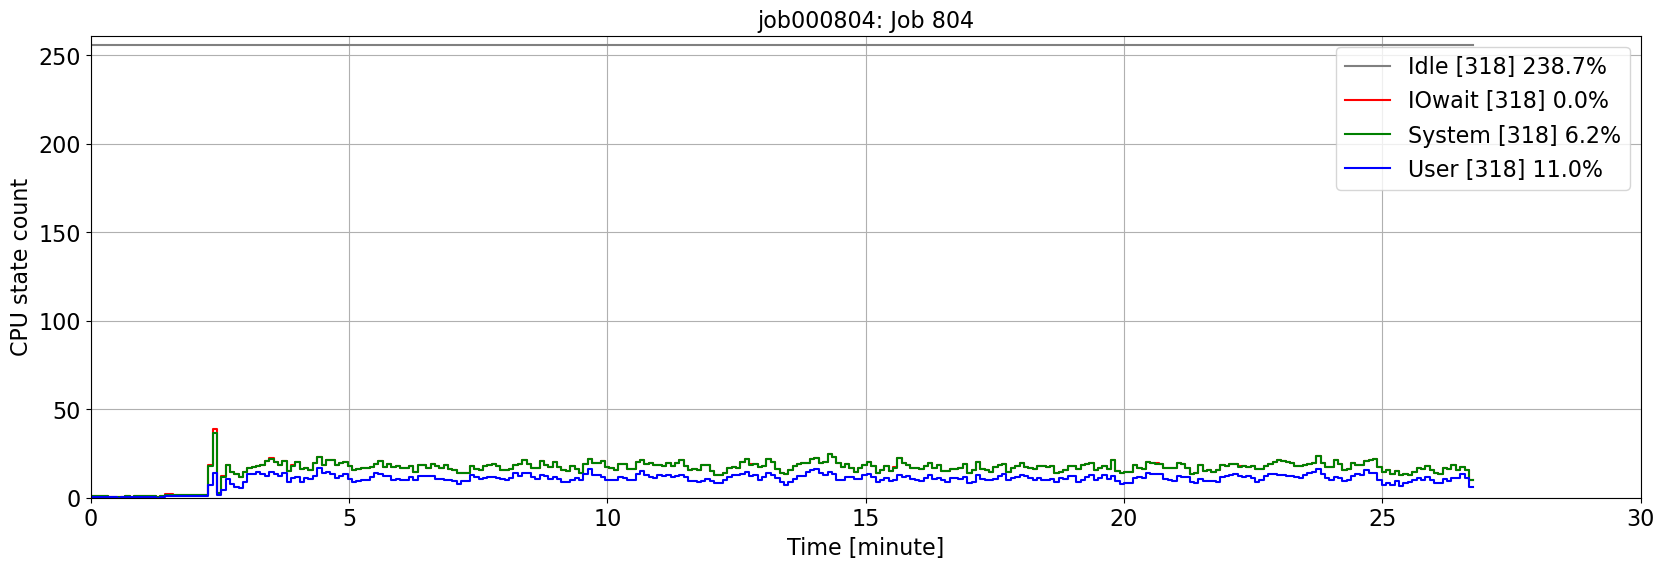

In [17]:
if havesym:
    xmin = tmin
    xmax = tmax
    ymin = 0
    fac = ncpu
    ymax = 1.02*fac
    cpusr = fac*sym.cpu_user/sym.cpu_time
    cpsys = fac*sym.cpu_system/sym.cpu_time
    cpiow = fac*sym.cpu_iowait/sym.cpu_time
    cpidl = fac*sym.cpu_idle/sym.cpu_time
    plt.figure(figsize=(pdx, pdy))
    plt.step(x=sym.tfix, y=cpusr+cpsys+cpiow+cpidl, color='gray', label=f"Idle [{len(cpidl)}] {cpidl.median():.1f}%") 
    plt.step(x=sym.tfix, y=cpusr+cpsys+cpiow, color='red', label=f"IOwait [{len(cpiow)}] {cpiow.median():.1f}%")
    plt.step(x=sym.tfix, y=cpusr+cpsys, color='green', label=f"System [{len(cpsys)}] {cpsys.median():.1f}%")
    plt.step(x=sym.tfix, y=cpusr, color='blue', label=f"User [{len(cpusr)}] {cpusr.median():.1f}%")
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('CPU state count')
    plt.grid(True)
    plt.legend()
    junk = plt.axis([xmin, xmax, ymin, ymax])
    plt.title(pttl)
    plt.savefig(pfx+'cpu-state-count'+sfx)

## Memory usage

The following plot shows the total memory used by the system and that used by running tasks.
The former is obtained from the system monitor and the latter from procsum.


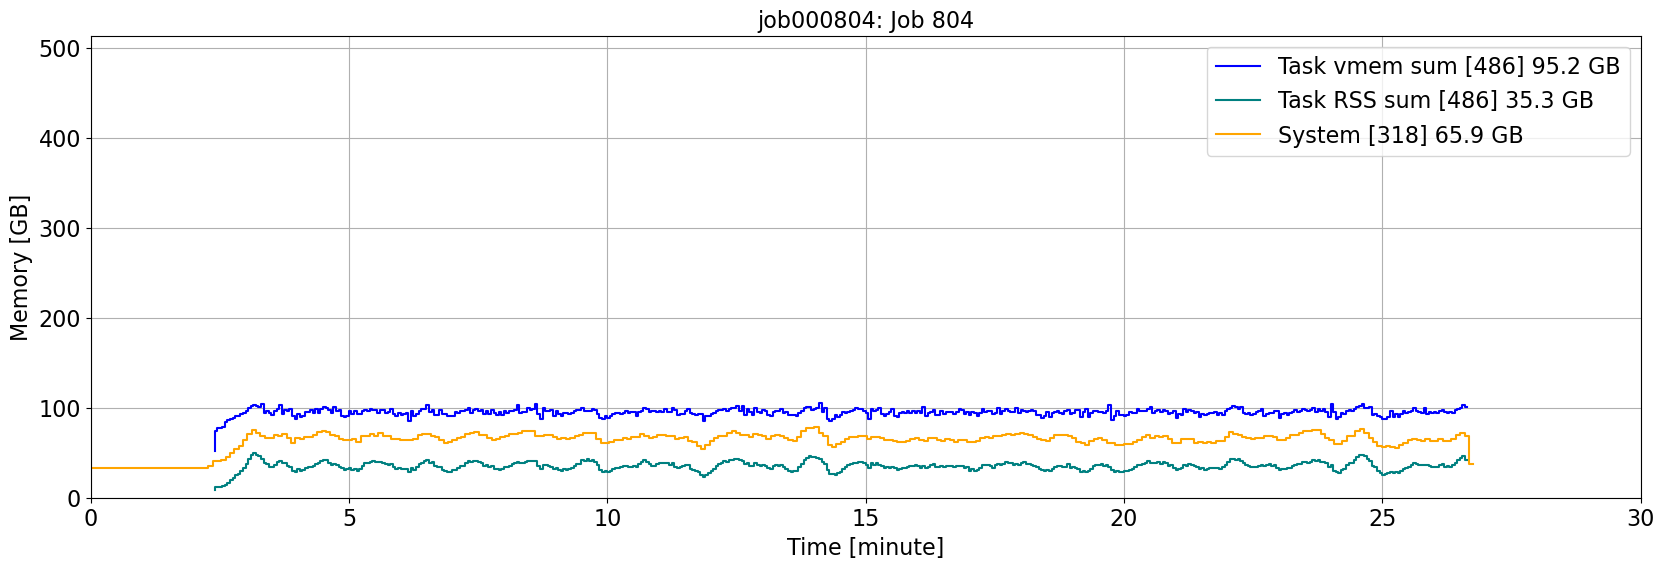

In [18]:
xmin = tmin
xmax = tmax
ymin = 0
ymax = 1.02*maxmem

plt.figure(figsize=(pdx, pdy))

if have_procsum:
    xdat2 = psm_tfix
    ydat2 = 1.e-12*psm.procsum_memory_virtual*maxmem
    lab2 = f"Task vmem sum [{len(ydat2)}] {ydat2.median():.1f} GB"
    plt.step(xdat2, ydat2, color='blue', label=lab2)
    ydat3 = 1.e-9*psm.procsum_memory_resident
    lab3 = f"Task RSS sum [{len(ydat3)}] {ydat3.median():.1f} GB"
    plt.step(xdat2, ydat3, color='teal', label=lab3)
    
xdat = sym.tfix
ydat = sym.mem_total - sym.mem_available
plt.step(xdat, ydat, color='orange', label=f"System [{len(ydat)}] {ydat.median():.1f} GB")

plt.xlabel(f"Time [{stunit}]")
plt.ylabel('Memory [GB]')
plt.grid(True)
plt.legend()
junk = plt.axis([xmin, xmax, ymin, ymax])
plt.title(pttl)
plt.savefig(pfx+'memory'+sfx)

## I/O rates

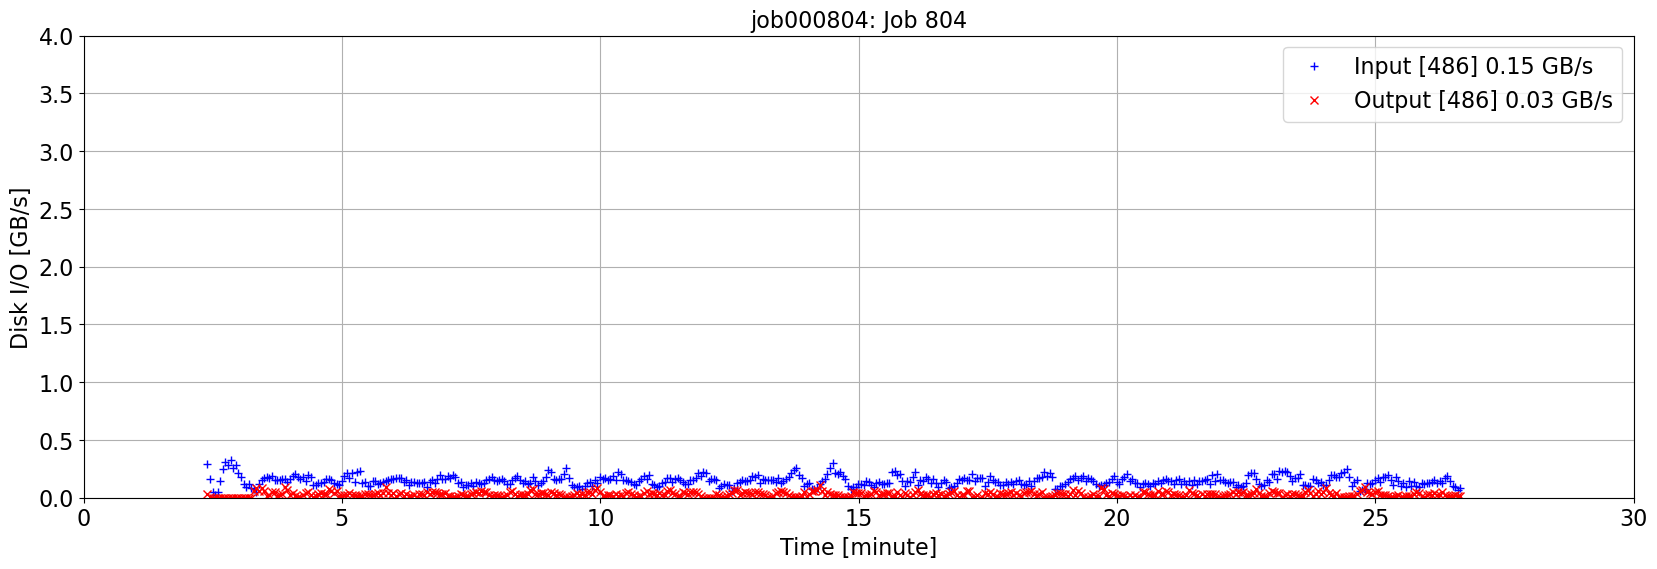

In [19]:
if have_procsum:
    plt.figure(figsize=(pdx, pdy))
    rea = psm.procsum_disk_read/gb/delt
    wri = psm.procsum_disk_write/gb/delt
    plt.plot(psm.tfix, rea, 'b+', label=f"Input [{len(rea)}] {rea.median():.2f} GB/s")
    plt.plot(psm.tfix, wri, 'rx', label=f"Output [{len(wri)}] {wri.median():0.2f} GB/s")
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('Disk I/O [GB/s]')
    plt.grid(True)
    plt.legend(loc="upper right")
    junk = plt.axis([tmin, tmax, 0, 4])
    plt.title(pttl)
    plt.savefig(pfx+'io'+sfx)
    plt.show()

 Read sum:    216.6 GB
Write sum:     43.3 GB


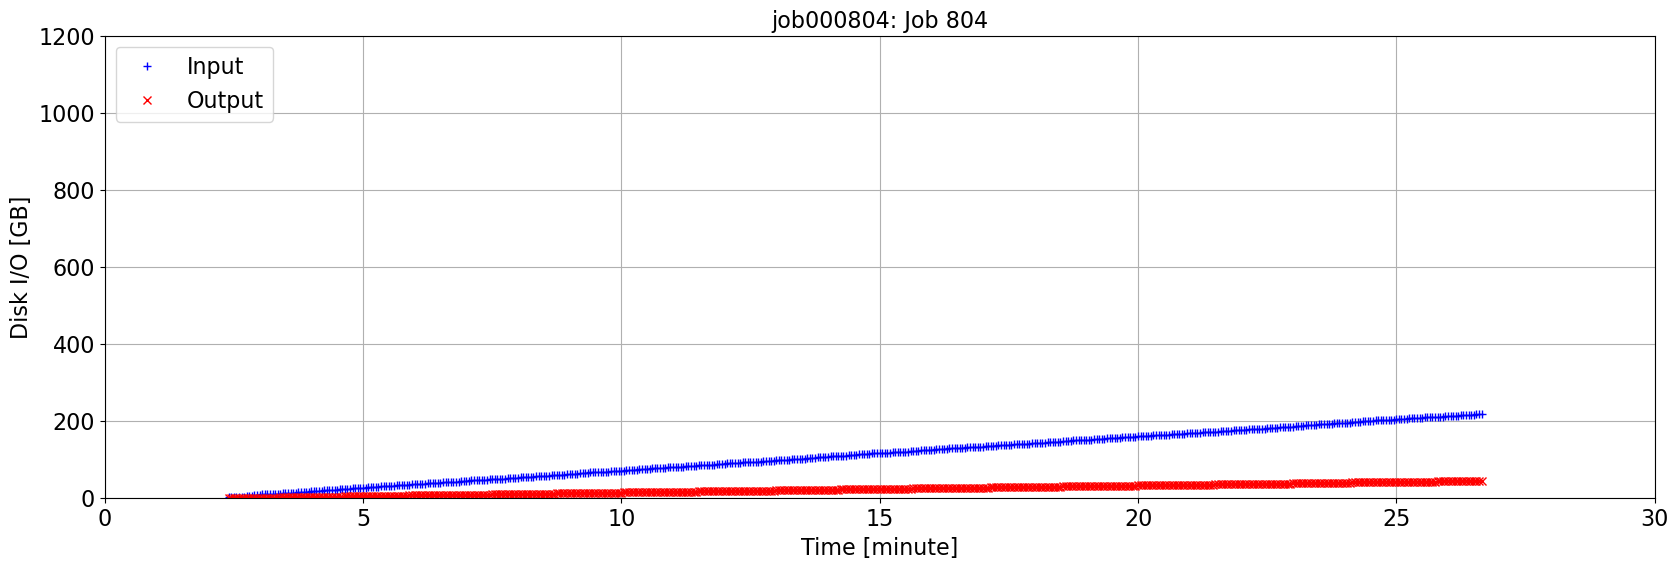

In [20]:
if have_procsum:
    xmin = tmin
    xmax = tmax
    ymin = 0.0
    ymax = monexp.iosummax
    plt.figure(figsize=(pdx, pdy))
    readgb = psm.procsum_disk_read.cumsum()/gb
    writgb = psm.procsum_disk_write.cumsum()/gb
    print(f" Read sum: {readgb.max():8.1f} GB")
    print(f"Write sum: {writgb.max():8.1f} GB")
    plt.plot(psm.tfix, readgb, 'b+', label='Input')
    plt.plot(psm.tfix, psm.procsum_disk_write.cumsum()/gb, 'rx', label='Output')
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('Disk I/O [GB]')
    plt.grid(True)
    plt.legend(loc="upper left")
    junk = plt.axis([xmin, xmax, ymin, ymax])
    #print(junk)
    plt.title(pttl)
    plt.savefig(pfx+'io2'+sfx)
    plt.show()
    #print(plt.rcParams)
    #print(psm.tfix, psm.procsum_disk_write.cumsum()/gb)

## Latency
Task submission latency is evaluated by assigning tasks to chains and defining the latency as the time between the end of one task and start of the next in a chain.
This latency estimate is suspect if the executor runs a variable number of workers.
For a fixed value, there is one chain per worker.

  Total chain count: 544
   Late chain count: 519
       Mean latency: 0.76 sec


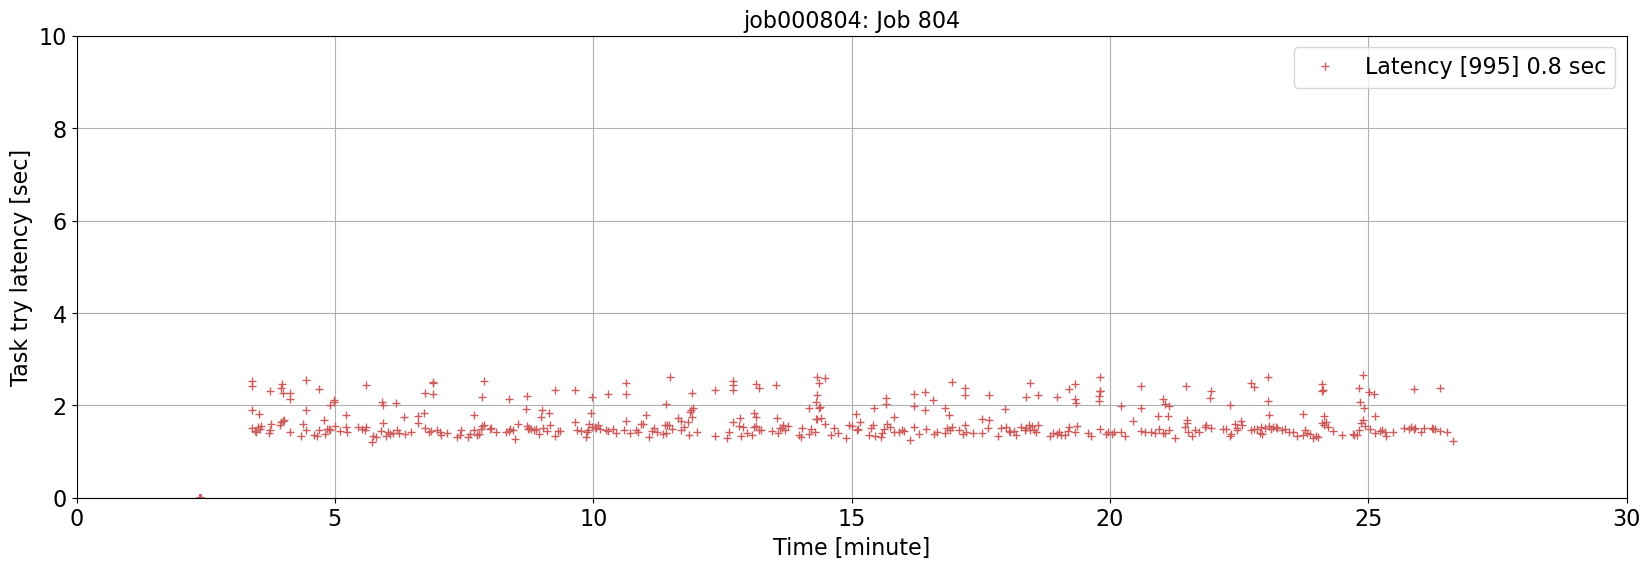

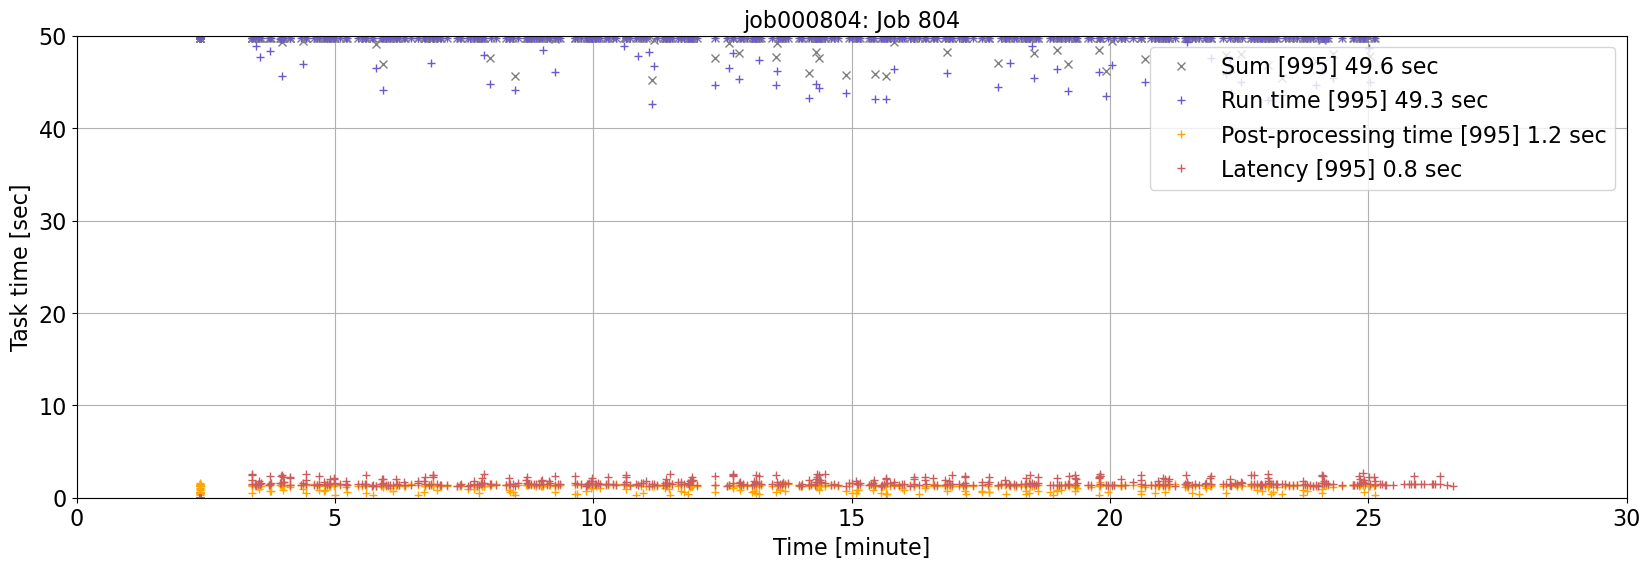

In [21]:
dbr.chaintasks()
print(f"  Total chain count: {dbr.taskchain_count('all')}")
print(f"   Late chain count: {dbr.taskchain_count('late')}")
print(f"       Mean latency: {tst.latency.mean():.2f} sec")
task_id_plot = monexp.task_id_plot
if isinstance(task_id_plot, int):
    task_idx_plot = task_id_plot
elif task_id_plot is not None:
    task_idx_plot = dbr.taskIndexFromName[task_id_plot]
if dbr.taskchain_count():
    xmin = tmin
    xmax = tmax
    ymin = 0
    ymax = monexp.tlatencymax
    if task_id_plot is None:
        ttst = tst
        tpttl = pttl
    else:
        print(f"Plotting only for task {task_id_plot}")
        ttst = tst.query(f"task_idx=={task_idx_plot}")
        tpttl = pttl + f" Task {task_id_plot}"
    tsklat = ttst.latency.clip(0,0.995*ymax)
    lablat = f"Latency [{len(tsklat)}] {ttst.latency.mean():.1f} sec"
    collat = 'indianred'
    plt.figure(figsize=(pdx, pdy))
    plt.plot(ttst.tfix_running, tsklat, color=collat, marker='+', linestyle='none', label=lablat)
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('Task try latency [sec]')
    plt.grid(True)
    plt.legend(loc="upper right")
    junk = plt.axis([xmin, xmax, ymin, ymax])
    plt.title(pttl)
    plt.savefig(pfx+'latency_vs_time'+sfx)
    plt.show()
    # Latency and run time
    ymin = 0
    ymax = monexp.tlatrunmax
    tsklat = ttst.latency.clip(0,0.995*ymax)
    tskrun = ttst['trun'].clip(0,0.995*ymax)
    tskpst = ttst['tpst'].clip(0, 0.995*ymax)
    labrun = f"Run time [{len(tsklat)}] {tskrun.mean():.1f} sec"
    labpst = f"Post-processing time [{len(tskpst)}] {tskpst.mean():.1f} sec"
    colrun = 'slateblue'
    colpst = 'orange'
    tsksum = (ttst.latency+ttst.trun+ttst.tpst).clip(0,0.995*ymax)
    labsum = f"Sum [{len(tsksum)}] {tsksum.mean():.1f} sec"
    colsum = 'gray'
    plt.figure(figsize=(pdx, pdy))
    mrk = '+'
    plt.plot(ttst.tfix_running, tsksum, color=colsum, marker='x', linestyle='none', label=labsum)
    plt.plot(ttst.tfix_running, tskrun, color=colrun,  marker=mrk, linestyle='none', label=labrun)
    plt.plot(ttst.tfix_running, tskpst, color=colpst,  marker=mrk, linestyle='none', label=labpst)
    plt.plot(ttst.tfix_running, tsklat, color=collat, marker=mrk, linestyle='none', label=lablat)
    plt.xlabel(f"Time [{stunit}]")
    plt.ylabel('Task time [sec]')
    plt.grid(True)
    plt.legend(loc="upper right")
    junk = plt.axis([xmin, xmax, ymin, ymax])
    plt.title(tpttl)
    plt.savefig(pfx+'latrun_vs_time'+sfx)
    plt.show()